In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import ast

In [2]:
stop = ["a", "al", "ante", "bajo", "cabe", "con", "contra", "de", "del", "desde", "con", "contra", "en", "entre", "hacia", "hasta", "para", "por", "según", "sin", "so", "sobre", "tras", "el", "la", "los", "las"]
def remove_stop(answer):
    for item in stop:
        r = answer.lower().find(item + " ")
        if r == 0:
            answer = answer[len(item)+1:]
    return answer
            

In [3]:
def save_file(df, my_file):
    x = open(my_file, "w")
    df.to_csv(my_file, sep='\t')
    x.close()
    print("Hem generat el fitxer", my_file)

In [4]:
directoryPath = "./sqac/"
filename = "test.json"
js = json.load(open(directoryPath + filename, encoding='utf-8'))
text_complet = js['data']

column_names = ["source", "id", "question", "answer", "answer_no_stop", "answer_start"]
df = pd.DataFrame(columns = column_names)  
for paragraph in text_complet:
    source = paragraph["source"]
    for context in text_complet[text_complet.index(paragraph)]['paragraphs']:
            a =  context['qas']    
            for element in a:
                question = element["question"]
                id = element['id']
                answers = element['answers'] 
                for ans in answers:
                    answer = ans['text']
                    answer_no_stop = remove_stop(answer)                   
                    thestart = ans["answer_start"]
      
                    df.loc[len(df.index)] = [source, id, question, answer, answer_no_stop, thestart] 

# Dataset

In [5]:
df

,source,id,question,answer,answer_no_stop,answer_start
0,wikipedia,56ea5a6b-c494-43fb-8af9-f084e1b3ff11,¿Cuál es el nombre que se le da a la unidad mo...,célula,célula,3
1,wikipedia,82ff0c00-c4a6-4677-af88-b9a05cce3b3f,"¿De dónde proviene el término ""célula"")","del latín cellula, diminutivo de cella, ‘celda’","latín cellula, diminutivo de cella, ‘celda’",11
2,wikipedia,7080811e-67c4-472f-94ce-afa1b69fb4a1,¿Cómo se denominan a los seres vivos con una ú...,unicelulares,unicelulares,328
3,wikipedia,8c5ab52a-3306-4389-ab5c-b5a394fbf77b,¿Dónde se encuentra el material genético en la...,el núcleo,núcleo,274
4,wikipedia,cb1d5d94-ae86-4167-a8df-1de5a8a83038,¿Cómo se llaman las células que necesitan las ...,gliales,gliales,640
...,...,...,...,...,...,...
1905,wikinews,58e72dc4-5c2a-444d-9d45-3db47f74b087,¿Cómo marcó gol Higuaín?,de volea,volea,449
1906,wikinews,726eaa9b-b8b9-4646-8612-fe76cf008b08,¿Cuál es el próximo contrincante de Argentina?,los Países Bajos,Países Bajos,1592
1907,wikinews,eb8e7345-8168-4b09-bc95-6607a32de1c2,¿Quién se ha impuesto en las elecciones para l...,El candidato pro-ruso Victor Yanukovich,candidato pro-ruso Victor Yanukovich,21
1908,wikinews,2dc32963-7057-465c-9c4f-edcef5525f2e,¿Qué porcentaje de apoyo ha logrado Yanukovich...,"48,49%","48,49%",208


# Respuestas del dataset + modelos

In [6]:
ans_column = ["answer"]
match_column = []
models = []

for filename in os.listdir(directoryPath):
    if filename[-4:] == "json" and filename != "test.json":
        print("afegint resultats", filename)
        file = open(directoryPath+filename, "r")
        dic = ast.literal_eval(file.read())
        model = filename[:-5]
        models.append(model)
        
        column_name = "answers_" + model
        ans_column.append(column_name)
        df[column_name] = ""
        
        no_stop = "no_stop_" + model
        df[no_stop] = ""
        
        match = "match_" + model
        df[match] = "no_match"
        match_column.append(match)
        
        for i, key in enumerate(dic):
            if key != df.loc[i, "id"]:
                print("error", filename, key)
                
            df.loc[i, column_name] = dic[key]
            no_stop_answer = remove_stop(dic[key])
            df.loc[i, no_stop] = no_stop_answer
            if dic[key] == df.loc[i, "answer"]:
                df.loc[i, match] = "exact"
            elif no_stop_answer == df.loc[i, "answer_no_stop"]:
                df.loc[i, match] = "no_stop"
            else:
                r = dic[key].find(df.loc[i, "answer"])
                s = df.loc[i, "answer"].find(dic[key])
                if r != -1 or s != -1:
                    df.loc[i, match] = "contains"
                    

afegint resultats bne_base_new.json
afegint resultats mbert.json
afegint resultats beto.json


In [7]:
df[ans_column]

,answer,answers_bne_base_new,answers_mbert,answers_beto
0,célula,La célula,La célula,La célula
1,"del latín cellula, diminutivo de cella, ‘celda’",del latín cellula,del latín cellula,del latín cellula
2,unicelulares,unicelulares,unicelulares,unicelulares
3,el núcleo,el núcleo,el núcleo,el núcleo
4,gliales,células gliales,las células gliales,células gliales
...,...,...,...,...
1905,de volea,de volea,remató de volea,remató de volea un balón que había rebotado en...
1906,los Países Bajos,Países Bajos,Bélgica,Bélgica
1907,El candidato pro-ruso Victor Yanukovich,El candidato pro-ruso Victor Yanukovich,El candidato pro-ruso Victor Yanukovich,El candidato pro-ruso Victor Yanukovich derrot...
1908,"48,49%","el 48,49%","el 48,49% de los votos, mientras que su rival ...","el 48,49%"


# Comparativa de los resultados de los modelos
* exact: la respuesta es exactamente igual a la del dataset. 
* no stop: la respuesta es igual si no se consideran los primeros stopword. Ej: _célula_ vs _la célula_
* contains: la respuesta del modelo contiene la respuesta del datset, o a la inversa. Ej _del latín cellula_ vs _del latín cellula, diminutivo de cella, ‘celda’_ 
* no: no hay ninguna coincidencia en las respuestas. Ej. _los Países Bajos_ vs _Bélgica_

In [8]:
def create_df_match(dataframe):
    sort_of_match = ["exact", "no_stop", "contains", "no_match"]
    df_match = pd.DataFrame(columns = sort_of_match) 
    dic = {}
    for match_model in match_column:
      #  print(match_model)
      #  print(dataframe[match_model].value_counts())
        values_list = dataframe[match_model].values.tolist()
        values_counts = []
        for som in sort_of_match:
            values_counts.append(round(values_list.count(som)/len(values_list), 2))
        dic[len(df_match.index)] = match_model
        df_match.loc[match_model] = values_counts
        
    return df_match
    

In [9]:
df_match = create_df_match(df)

In [10]:
df_match

,exact,no_stop,contains,no_match
match_bne_base_new,0.58,0.07,0.20,0.15
match_mbert,0.57,0.06,0.20,0.17
match_beto,0.60,0.06,0.18,0.15


<AxesSubplot:>

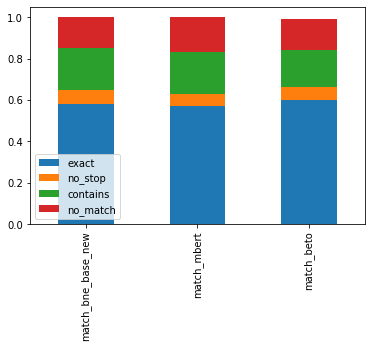

In [11]:
df_match.plot.bar(stacked=True)

## Resultados por modelo según fuente

In [12]:
def results_by_source(match_model):
    sort_of_match = ["exact", "no_stop", "contains", "no_match"]
    sources = ["wikipedia", "ancora", "wikinews"]
    df_match = pd.DataFrame(columns = sort_of_match) 
    for source in sources:
        values_list = df[df['source']==source][match_model].values.tolist()
        values_counts = []
        for som in sort_of_match:
            values_counts.append(round(values_list.count(som)/len(values_list),2))
        df_match.loc[source] = values_counts
    return df_match
    

## bne_base_new

In [13]:
results_by_source("match_bne_base_new")

,exact,no_stop,contains,no_match
wikipedia,0.54,0.06,0.25,0.15
ancora,0.61,0.09,0.16,0.15
wikinews,0.62,0.06,0.16,0.16


<AxesSubplot:>

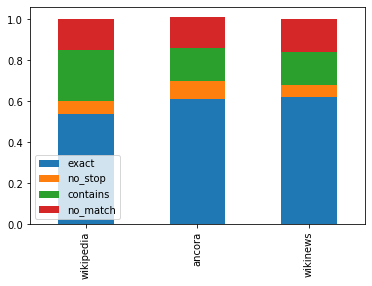

In [14]:
results_by_source("match_bne_base_new").plot.bar(stacked=True)

## mbert

In [15]:
results_by_source("match_mbert")

,exact,no_stop,contains,no_match
wikipedia,0.56,0.06,0.21,0.17
ancora,0.59,0.07,0.17,0.17
wikinews,0.57,0.05,0.20,0.18


<AxesSubplot:>

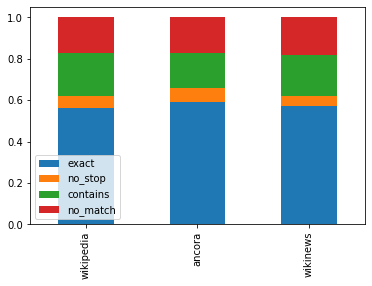

In [16]:
results_by_source("match_mbert").plot.bar(stacked=True)

## beto

In [17]:
results_by_source("match_beto")

,exact,no_stop,contains,no_match
wikipedia,0.57,0.06,0.21,0.15
ancora,0.63,0.06,0.17,0.14
wikinews,0.63,0.04,0.16,0.17


<AxesSubplot:>

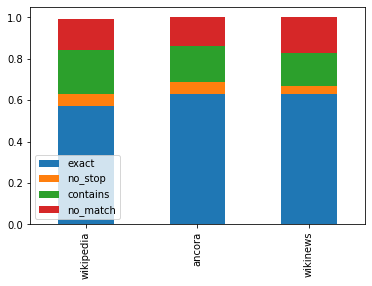

In [18]:
results_by_source("match_beto").plot.bar(stacked=True)

# Respuestas del bne_base_new

In [19]:
df[["answer", "answers_bne_base_new", "match_bne_base_new"]]

,answer,answers_bne_base_new,match_bne_base_new
0,célula,La célula,no_stop
1,"del latín cellula, diminutivo de cella, ‘celda’",del latín cellula,contains
2,unicelulares,unicelulares,exact
3,el núcleo,el núcleo,exact
4,gliales,células gliales,contains
...,...,...,...
1905,de volea,de volea,exact
1906,los Países Bajos,Países Bajos,no_stop
1907,El candidato pro-ruso Victor Yanukovich,El candidato pro-ruso Victor Yanukovich,exact
1908,"48,49%","el 48,49%",no_stop


In [20]:
#my_file = directoryPath + "alt_ans.csv"
for model in models:
    save_file(df[["answer", "answers_" + model, "match_" + model]], directoryPath + "ans_" + model + ".csv")

Hem generat el fitxer ./sqac/ans_bne_base_new.csv
Hem generat el fitxer ./sqac/ans_mbert.csv
Hem generat el fitxer ./sqac/ans_beto.csv


# Comparativa de los modelos según la fuente

In [21]:
df["source"].value_counts()

wikipedia    867
ancora       544
wikinews     499
Name: source, dtype: int64

## Wikipedia

In [22]:
df_match = create_df_match(df[df['source']=="wikipedia"])
df_match

,exact,no_stop,contains,no_match
match_bne_base_new,0.54,0.06,0.25,0.15
match_mbert,0.56,0.06,0.21,0.17
match_beto,0.57,0.06,0.21,0.15


<AxesSubplot:>

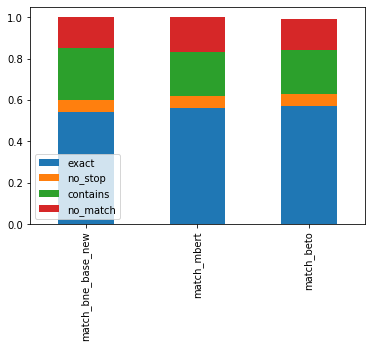

In [23]:
df_match.plot.bar(stacked=True)

## Ancora

In [24]:
df_match = create_df_match(df[df['source']=="ancora"])
df_match

,exact,no_stop,contains,no_match
match_bne_base_new,0.61,0.09,0.16,0.15
match_mbert,0.59,0.07,0.17,0.17
match_beto,0.63,0.06,0.17,0.14


<AxesSubplot:>

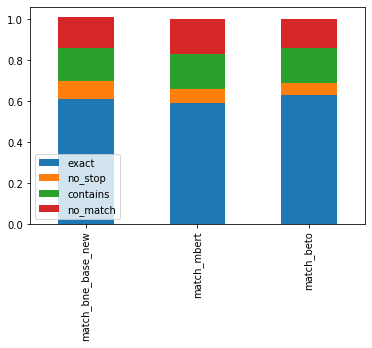

In [25]:
df_match.plot.bar(stacked=True)

## Wikinews

In [26]:
df_match = create_df_match(df[df['source']=="ancora"])
df_match

,exact,no_stop,contains,no_match
match_bne_base_new,0.61,0.09,0.16,0.15
match_mbert,0.59,0.07,0.17,0.17
match_beto,0.63,0.06,0.17,0.14


<AxesSubplot:>

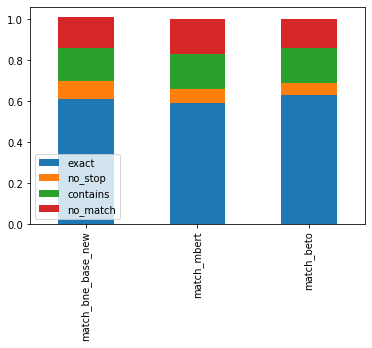

In [27]:
df_match.plot.bar(stacked=True)

# Análisis de las respuestas

In [28]:
df_all_ok = pd.DataFrame(columns = ["id", "question", "answer", "source"]) 
df_alt_ans = pd.DataFrame(columns = ["id", "question", "answer", "alt_answer", "match", "source"]) 
df_1h = pd.DataFrame(columns = ["id", "question", "answer", "bne_base_new", "mbert", "beto", "model_dif", "source"]) 
columns = ["answer_no_stop"]
for model in models:
    columns.append("no_stop_" + model)
    
for k,row in df.iterrows():
    results = []
    r_columns = columns[:] 
    for column in columns:
        r_columns.pop(0)
        if len(r_columns) > 0:
            for r_column in r_columns:
                if df.loc[k, column] == df.loc[k, r_column]:
                    results.append("True")
                else:
                    results.append("False")
        dataset_results = results[:len(models)]
        models_results = results[len(models):]
    if dataset_results.count("True") == len(models):
        df_all_ok.loc[len(df_all_ok.index)] = [df.loc[k, "id"], df.loc[k, "question"], df.loc[k, "answer_no_stop"], df.loc[k, "source"]]
    elif dataset_results.count("True") == 1:
        for i, r in enumerate(dataset_results):
            if r == "True":
                model_dif = models[i]              
        df_1h.loc[len(df_all_ok.index)] = [df.loc[k, "id"], df.loc[k, "question"], df.loc[k, "answer_no_stop"], df.loc[k, "no_stop_bne_base_new"], df.loc[k, "no_stop_mbert"], df.loc[k, "no_stop_beto"], model_dif, df.loc[k, "source"]]
    elif dataset_results.count("True") == 0:
        if models_results.count("True") == len(models_results):
            df_alt_ans.loc[len(df_all_ok.index)] = [df.loc[k, "id"], df.loc[k, "question"], df.loc[k, "answer_no_stop"], df.loc[k, "no_stop_bne_base_new"], df.loc[k, "match_bne_base_new"], df.loc[k, "source"]] 
    
        
    

## Preguntas en que todos los modelos han dado la misma respuesta, igual al dataset

In [29]:
df_all_ok

,id,question,answer,source
0,56ea5a6b-c494-43fb-8af9-f084e1b3ff11,¿Cuál es el nombre que se le da a la unidad mo...,célula,wikipedia
1,7080811e-67c4-472f-94ce-afa1b69fb4a1,¿Cómo se denominan a los seres vivos con una ú...,unicelulares,wikipedia
2,8c5ab52a-3306-4389-ab5c-b5a394fbf77b,¿Dónde se encuentra el material genético en la...,núcleo,wikipedia
3,ad218c32-a803-43db-9b2d-19cf3d969f1d,¿Cuál es el componente primordial de la pared ...,celulosa,wikipedia
4,eeaeee34-405a-4ddd-bbea-330c459c46a6,¿Qué instrumento permitió el estudio de las cé...,microscopio rudimentario de lentes compuestas,wikipedia
...,...,...,...,...
946,a0f32196-8a01-4c34-b3b7-250c4d6eddb9,¿A qué países viaja Condoleezza Rice?,"Brasil, Colombia, Chile y El Salvador",wikinews
947,8b7753c6-c27e-4b13-bb64-8b33710a3c90,¿Qué temas tratará Condoleezza Rice durante su...,"tráfico de drogas y crimen, reducción de la po...",wikinews
948,d3284ee0-7209-46eb-b83c-645df6fd5af6,¿Cuál es la forma del parque de la Ciudadela e...,semicircular,wikipedia
949,7ba2a5a8-6ea4-4035-930a-9aab6e3c4644,¿Quién fue Joaquim Renart?,"un pintor, decorador y coleccionista, fundador...",wikipedia


## Preguntas en las que todos los modelos han dado la misma respuesta, distinta al dataset

In [30]:
df_alt_ans

,id,question,answer,alt_answer,match,source
1,82ff0c00-c4a6-4677-af88-b9a05cce3b3f,"¿De dónde proviene el término ""célula"")","latín cellula, diminutivo de cella, ‘celda’",latín cellula,contains,wikipedia
3,cb1d5d94-ae86-4167-a8df-1de5a8a83038,¿Cómo se llaman las células que necesitan las ...,gliales,células gliales,contains,wikipedia
5,0e6afdc9-57a7-46b4-89cf-7923fe47d4ac,¿Cómo se logran resultados más decisivos respe...,mediante los estudios de microscopía electróni...,mediante los estudios de microscopía electróni...,contains,wikipedia
17,7e03463b-c0f8-45b9-8145-10839a3784b8,¿Dónde fueron descubiertos los restos históricos?,distrito de Aïn Shams,"distrito de Aïn Shams, al este de El Cairo",contains,wikinews
19,75237723-d90d-4c14-8cbb-7aab4701a1b3,¿Cuál es la confederación con un menor porcent...,AFC,Concacaf,no_match,wikipedia
...,...,...,...,...,...,...
923,a3766822-646d-4142-9536-6feff3cd5ca0,¿La luz de qué planeta se relaciona con el pen...,de la Luna,Luna,contains,wikipedia
933,2ac11ff1-32bf-4d7c-a904-049027d6d14d,¿Cuándo se estrenó la primera película de cine...,1934,20 de mayo de 1897,no_match,wikipedia
934,5d544319-40c2-4b03-974a-071836a0766b,¿Cuándo se produjo el choque?,alrededor de las 15:40 [hora local],alrededor de las 15:40 [hora local,contains,wikinews
945,91ade7b1-c915-4e03-ad44-5828d4421b9d,¿A cuánta distancia puede llegar el cañón de n...,cincuenta metros,más de cincuenta metros,contains,ancora


In [31]:
save_file(df_alt_ans, directoryPath + "alt_ans.csv")

Hem generat el fitxer ./sqac/alt_ans.csv


In [32]:
df_alt_ans["match"].value_counts()

contains    103
no_match     39
Name: match, dtype: int64

### Preguntas en las que todos los modelos han dado la misma respuesta, que no coincide en nada con la del dataset
(subconjunto de la tabla anterior)

In [33]:
df_alt_ans[df_alt_ans["match"]=="no_match"]

,id,question,answer,alt_answer,match,source
19,75237723-d90d-4c14-8cbb-7aab4701a1b3,¿Cuál es la confederación con un menor porcent...,AFC,Concacaf,no_match,wikipedia
24,7a0f986c-dd53-4917-96aa-8979bc8a7c74,¿Cuándo comenzaron las manifestaciones en el p...,elecciones legislativas del pasado 15 de mayo,lunes,no_match,wikinews
28,b7d6f4ea-126a-49c0-b244-af478a0356af,¿Qué puede causar que dejes tu equipo?,motivos profesionales,una mala racha,no_match,ancora
31,ff10c022-a4be-4db7-8a40-653e72c0538c,¿Cómo se declaraba el pueblo de Yugoslavia dur...,favorable a los Aliados,neutral,no_match,wikipedia
71,6103a299-6f4d-4bad-b229-11ebc95ee1f1,¿Cuándo se tradujo por primera vez al español ...,1777,1802 y 1807,no_match,wikipedia
91,474b9093-2478-4798-86e0-8f7493fbaaeb,¿Cuánto aumentaron los márgenes de las peras p...,un seis por ciento,62 por ciento,no_match,ancora
122,4380f375-42af-4529-b961-7e5cdd2197f4,¿Cuál era el nombre de Tallin tras la independ...,Tallinna,Reval,no_match,wikipedia
131,7630c71d-0c0e-4856-a2b2-d76d8020b5e2,¿Cómo se conoce también en castellano a las mu...,Damas del Imperio Invisible,Ku Klux Klan Women,no_match,wikipedia
156,7ceb2a51-f30e-48ef-aaf1-7a558f5a6dd5,¿Cómo se piensa que mejoraría la diversidad de...,disminuyendo el tamaño de las cuencas oceánicas,más abundante en aguas poco profundas,no_match,wikipedia
162,66f4324c-91ca-4426-8b7d-52a2ce65a9b6,¿Dónde se dice que los resultados de ADN sobre...,libro titulado The Riddle of Anna Anderson,prensa,no_match,wikipedia


In [34]:
df_alt_ans[df_alt_ans["match"]=="no_match"]["source"].value_counts()
save_file(df_alt_ans[df_alt_ans["match"]=="no_match"], directoryPath + "alt_ans_no_match.csv")

Hem generat el fitxer ./sqac/alt_ans_no_match.csv


## Preguntas en las que solo un modelo ha dado la misma respuesta que el dataset

In [35]:
df_1h

,id,question,answer,bne_base_new,mbert,beto,model_dif,source
12,8fcfdad5-52ca-466a-9281-b7807a6cea04,¿Contra qué protestaban los buques argentinos?,limitaciones impuestas a la captura de merluza,decisión del Gobierno argentino por las limita...,limitaciones impuestas a la captura de merluza,decisión del Gobierno argentino por las limita...,mbert,ancora
15,715c4249-f08b-455d-9da1-e973c58d72c2,¿Dónde se localizó el epicentro del seísmo?,"50 km bajo tierra en la prefectura de Ibaraki,...","50 km bajo tierra en la prefectura de Ibaraki,...",prefectura de Ibaraki,centro de Japón,bne_base_new,wikinews
19,6b874d4b-1d54-44a3-8f47-ac15bdb0f17e,¿Qué porcentaje de la población mundial juega ...,4 %,4 %,alrededor del 4 %,alrededor del 4 %,bne_base_new,wikipedia
20,a9694543-cf58-4be1-9ca7-a025117b2911,¿Cuál es la probabilidad que tienen las orcas ...,extremadamente alta,37 y 50 % de las crías,extremadamente alta,37 y 50 %,mbert,wikipedia
31,f4395ed9-f089-4f39-b03d-09b660094f19,¿Cuál fue la posición que adoptó el gobierno y...,neutral,se declaró neutral,neutral,se declaró neutral,mbert,wikipedia
...,...,...,...,...,...,...,...,...
926,1b9306c7-770e-4d7b-adef-eeed0c8d15ba,¿Qué rango militar tenía Augusto Pinochet?,Capitán General del Ejército (r) de Chile,ex presidente y Capitán General del Ejército,Capitán General del Ejército (r) de Chile,ex presidente y Capitán General,mbert,wikinews
928,c7977ccc-ae32-40c7-a096-7f163873f20d,¿Cómo se terminan los conflictos?,fuerza de situar la justicia sobre todas las c...,fuerza de situar la justicia sobre todas las c...,fuerza de situar la justicia sobre todas las c...,fuerza de situar la justicia sobre todas las c...,mbert,ancora
930,ff6f9cdf-245c-4a1e-a999-24301045c637,¿De qué se podría acusar a Israel según revela...,utilización de bombas de uranio en el Líbano,bombas anti búnker en la población de Khiam al...,utilizó bombas anti búnker en la población de ...,utilización de bombas de uranio en el Líbano,beto,wikinews
936,77c9be4e-b200-4ec4-814a-02d5dd2e14f3,¿Cuándo finalizan las campañas de los que quie...,este miércoles (28,este miércoles (28,este miércoles,este miércoles,bne_base_new,wikinews


In [36]:
df_1h["model_dif"].value_counts(normalize=True)

bne_base_new    0.378788
beto            0.333333
mbert           0.287879
Name: model_dif, dtype: float64

In [37]:
df_1h["source"].value_counts(normalize=True)

wikipedia    0.464646
wikinews     0.287879
ancora       0.247475
Name: source, dtype: float64